# Credit Card Fraud Detection

We try to identify fraudulent credit card transactions so that the customers are not charged for items that they did not purchase.   
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import collections

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

## Loading the dataset

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.sum().isnull().any()

False

## Exploratory Data Analysis (EDA)

In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
print(f"No Frauds: {round((df['Class'].value_counts()[0] / len(df)) * 100, 2)} % of the dataset")
print(f"Frauds: {round((df['Class'].value_counts()[1] / len(df)) * 100, 2)} % of the dataset")

No Frauds: 99.83 % of the dataset
Frauds: 0.17 % of the dataset


You can notice that the dataset is very imbalanced. Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

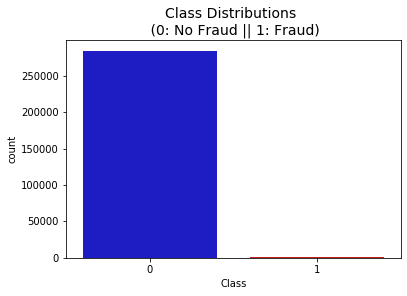

In [9]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

**Distributions**: By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook in the future.

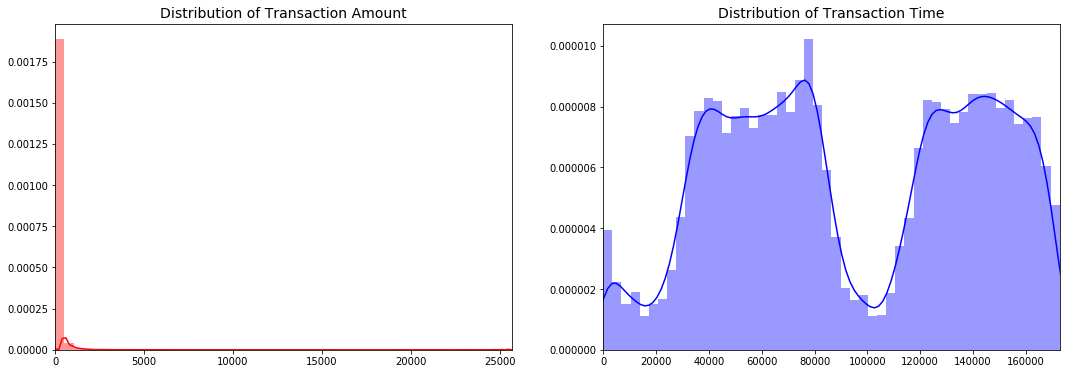

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim(min(amount_val), max(amount_val))

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim(min(time_val), max(time_val))

plt.show()

### Scaling
We scale the **Time** and **Amount** features using Robust Scaler. 

### Sub-Sampling
We create a subsample of the dataset in order to have the same amount of Fraud and Non-Fraud cases which helps our algorithm better understand patterns whether a transaction is fraud or not. This is done so because the dataset is heavily imbalanced and training the dataset without sub-sampling leads to two problems:
1. Overfitting: As the majority class in the dataset is Non-Fraud, the algorithm which we use to train the dataset might be misleaded by the ratio of the majority instances to the minority.
2. Wrong Correlations: Although we don't what the 'V' features represent, it might be useful to understand the correlations between various features. Since the dataset is imbalanced, we might not observe the true correlations unless we sub-sample.

In [11]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [12]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Splitting the data
We split the dataset using StratifiedKFold which provides train/test indices to split data in train/test sets. The folds are made by preserving the percentage of samples for each class.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop(['Class'], axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print('Train:', train_index, 'Test:', test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
          
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values
          
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 108)

print('Label Distributions:')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
------------------------------------------------------------------------------------------------------------
Label Distributions:
[0.99827076 0.00172924]
[0.99827952 0.00172048]


### Random Under-Sampling:
<ul>
<li>We have determined the number of Fraud and Non-Fraud instances and have concluded that it is an imbalanced dataset.</li>
<li>So, we take equal number of instances of Fraud and Non-Fraud (492 each) achieving a ratio of 50/50.</li>
</ul>

In [14]:
df = df.sample(frac=1)
fraud_df = df.loc[df['Class']==1]
non_fraud_df = df.loc[df['Class']==0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
211072,-0.195626,0.629190,-0.521586,1.131081,0.602248,2.499135,2.254733,0.488866,1.339769,-0.094819,...,-0.036439,0.338730,0.995461,-0.473147,0.301545,0.379048,0.226204,-0.108789,-0.091448,0
150687,-0.293440,0.108143,-10.300820,6.483095,-15.076363,6.554191,-8.880252,-4.471672,-14.900689,3.840170,...,0.113244,1.508748,1.041642,-0.682790,0.573544,-1.602389,-0.393521,-0.468893,0.105920,1
210365,0.142528,0.625642,-0.051578,0.879925,-0.517663,-0.312413,1.155171,-0.984537,1.120527,-0.288039,...,0.031768,0.317798,0.978926,-0.253937,-0.712533,-0.371527,-0.121750,0.218219,0.241954,0
208651,0.243834,0.617007,0.630579,1.183631,-5.066283,2.179903,-0.703376,-0.103614,-3.490350,1.094734,...,0.357369,0.621622,0.043807,0.102711,-0.601505,0.127371,-0.163009,0.853792,0.356503,1
150669,2.326836,0.107708,-10.632375,7.251936,-17.681072,8.204144,-10.166591,-4.510344,-12.981606,6.783589,...,-0.810146,2.715357,0.695603,-1.138122,0.459442,0.386337,0.522438,-1.416604,-0.488307,1


In [15]:
new_df.shape

(984, 31)

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


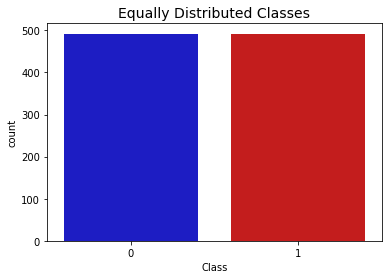

In [16]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

Here, we can see that the instances of each class are equally distributed.

### Correlation Matrices 
Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample) in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

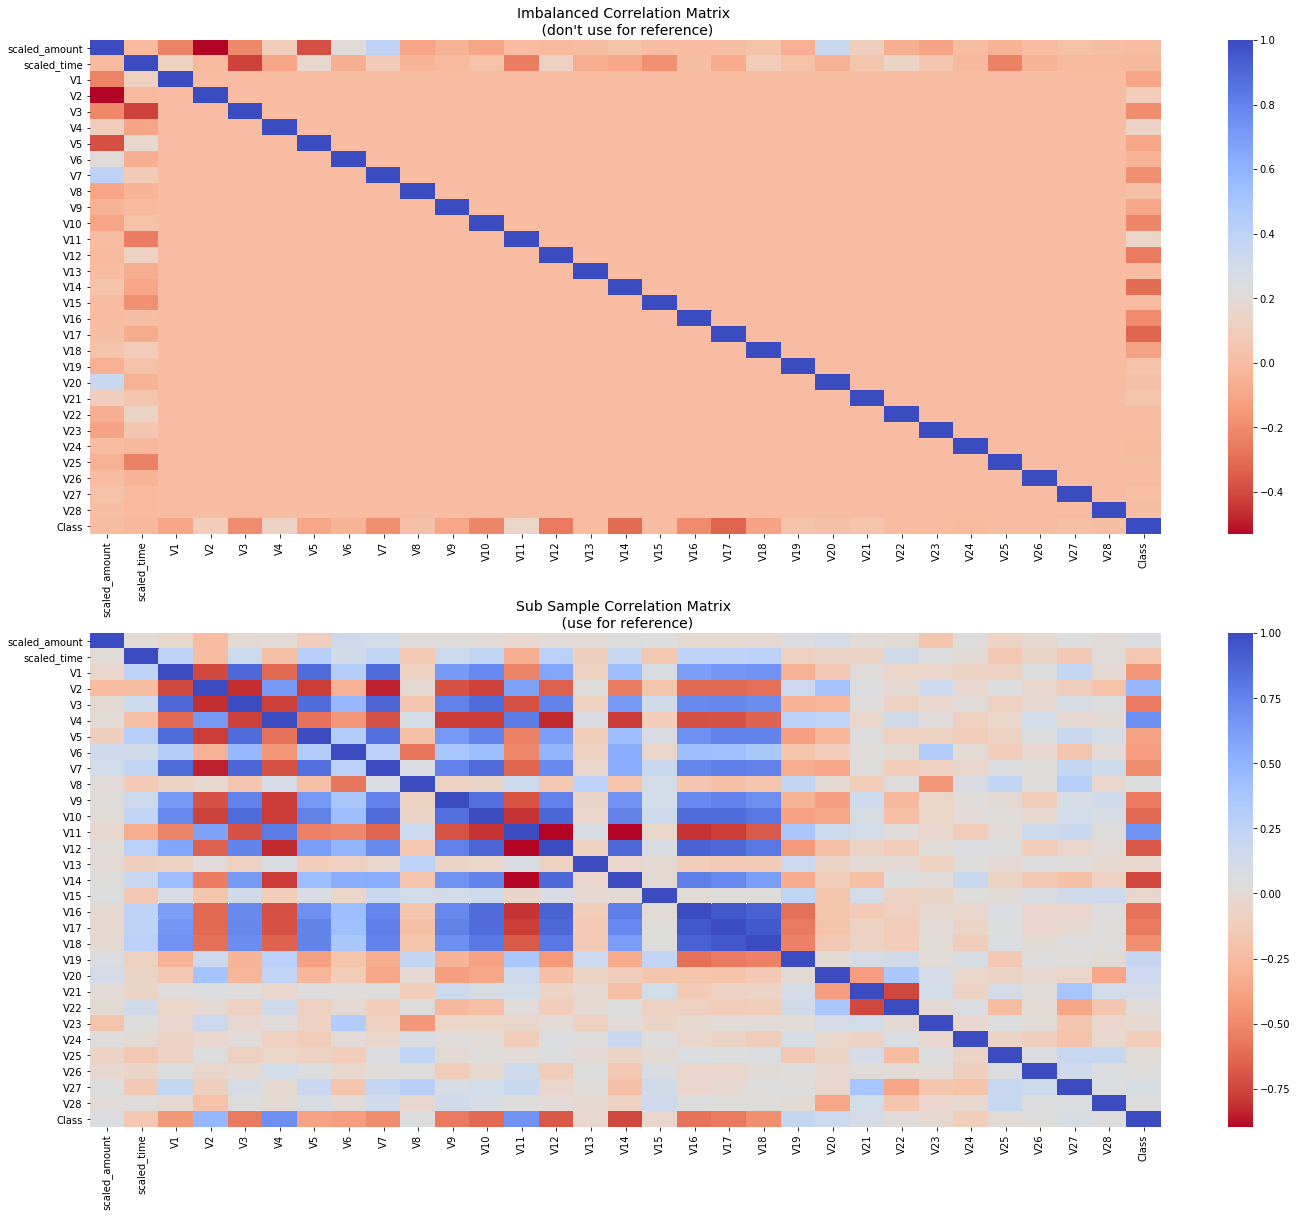

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title("Sub Sample Correlation Matrix \n (use for reference)", fontsize=14)

plt.show()

In [18]:
new_df.corr()['Class'].sort_values()

V14             -0.748983
V12             -0.682918
V10             -0.628512
V16             -0.591051
V17             -0.563525
V3              -0.559950
V9              -0.557269
V7              -0.481261
V18             -0.467680
V1              -0.426129
V6              -0.404104
V5              -0.375723
scaled_time     -0.163607
V24             -0.125998
V15             -0.034352
V13             -0.023804
V23             -0.014854
V25              0.008281
V22              0.022605
V26              0.039410
V28              0.045105
V8               0.063876
scaled_amount    0.072622
V27              0.102077
V21              0.117627
V20              0.173833
V19              0.203214
V2               0.479462
V11              0.683028
V4               0.696159
Class            1.000000
Name: Class, dtype: float64

The observations made through studying the correlation matrices are:
<ul>
<li><b>Negative Correlations: </b>V14, V12, V10 and V16 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.  </li>
<li> <b> Positive Correlations: </b> V4, V11, V2, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction. </li>
</ul>

**BoxPlots**: We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.

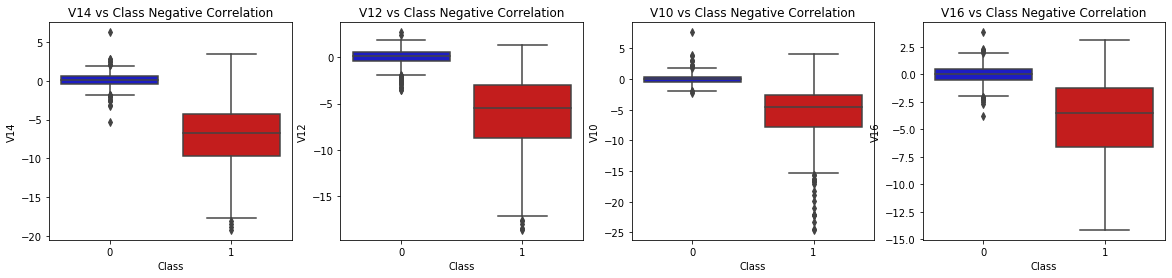

In [19]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

l = ['V14', 'V12', 'V10', 'V16']

for i in range(4):
    sns.boxplot(x='Class', y=l[i], data=new_df, palette=colors, ax=axes[i])
    axes[i].set_title(f'{l[i]} vs Class Negative Correlation')

plt.show()

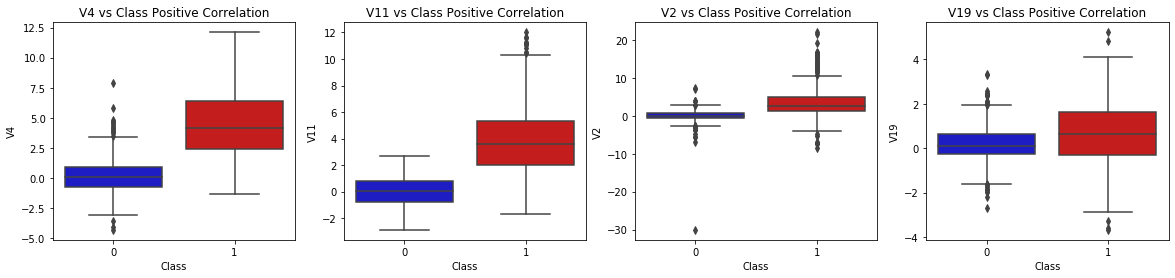

In [20]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

l = ['V4', 'V11', 'V2', 'V19']

for i in range(4):
    sns.boxplot(x='Class', y=l[i], data=new_df, palette=colors, ax=axes[i])
    axes[i].set_title(f'{l[i]} vs Class Positive Correlation')

plt.show()

## Anomaly Detection:
Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models. <br>

### Interquartile Range Method:
<ul>
<li> <b>Interquartile Range (IQR): </b> We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted.  </li>
<li> <b>Boxplots: </b> Besides easily seeing the 25th and 75th percentiles (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme). </li>
</ul>

### Outlier Removal Tradeoff:
We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.  <br>

**The Tradeoff:**
The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.

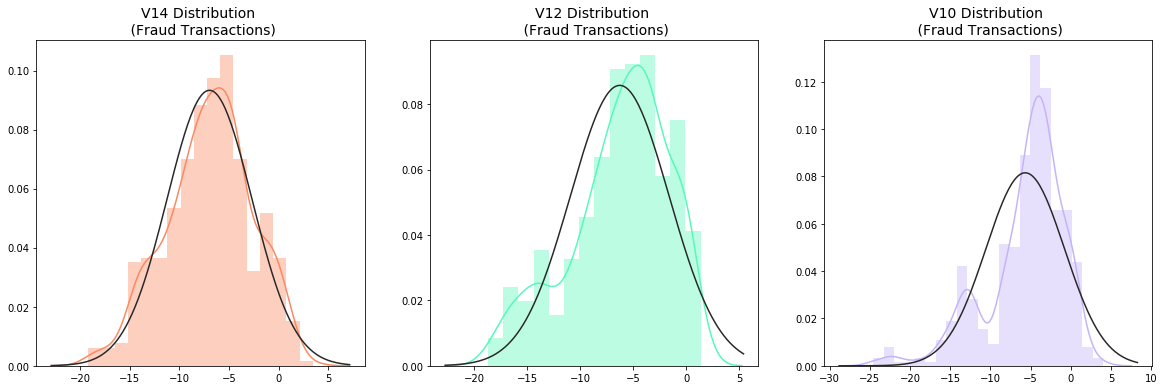

In [21]:
from scipy.stats import norm

f, axes = plt.subplots(1,3, figsize=(20, 6))

l = ['V14', 'V12', 'V10']
colors = ['#FB8861', '#56F9BB', '#C5B3F9']

for i in range(3):
    b = new_df[l[i]].loc[new_df['Class'] == 1].values
    sns.distplot(b, ax=axes[i], fit=norm, color=colors[i])
    axes[i].set_title(f'{l[i]} Distribution \n (Fraud Transactions)', fontsize=14)
plt.show()

<li> <b> Visualize Distributions: </b> We first start by visualizing the distribution of the feature we are going to use to eliminate some of the outliers. V14 is the only feature that has a Gaussian distribution compared to features V12 and V10. </li>
<li><b>Determining the threshold: </b> After we decide which number we will use to multiply with the iqr (the lower more outliers removed), we will proceed in determining the upper and lower thresholds by substrating q25 - threshold (lower extreme threshold) and adding q75 + threshold (upper extreme threshold). </li>
<li> <b>Conditional Dropping: </b> Lastly, we create a conditional dropping stating that if the "threshold" is exceeded in both extremes, the instances will be removed. </li>

In [22]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.4937733551053, -19.2143254902614, -18.8220867423816, -18.049997689859396]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.047596570821604, -18.683714633344298, -18.553697009645802, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 975
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-14.9246547735487, -

<br>

### **Boxplot Representation**: 
Visualizing through the boxplot that the number of "extreme outliers" have been reduced to a considerable amount.

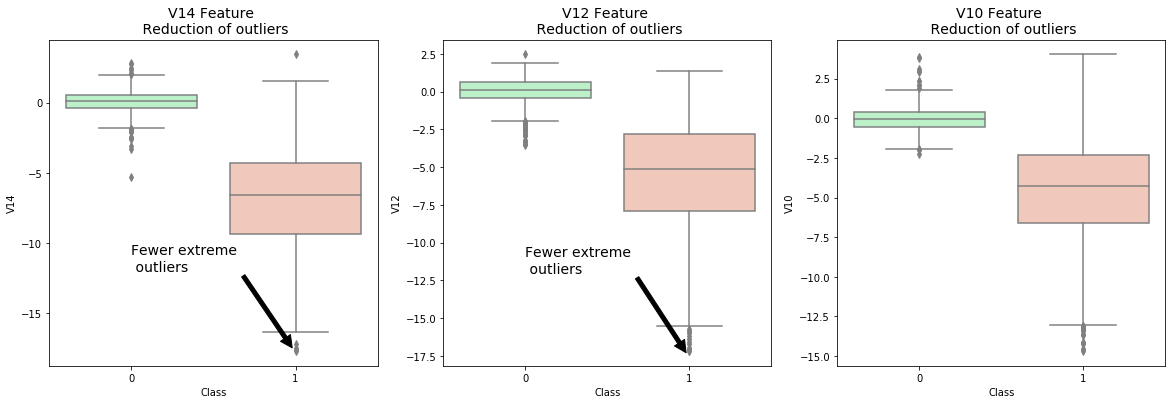

In [23]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

## Dimensionality Reduction and Clustering:

### Understanding t-SNE:

<ul>
<li>t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data.</li>
<li>In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space.</li>
<li>The t-SNE algorithm calculates a similarity measure between pairs of instances in the high dimensional space and in the low dimensional space. It then tries to optimize these two similarity measures using a cost function. It then tries to optimize these two similarity measures using a cost function.</li>
</ul> 

### Principal Component Analysis
<ul>
<li>Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.</li>
<li>Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity.</li>
</ul>

### Truncated SVC
Truncatred SVC performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). It is very similar to PCA, but operates on sample vectors directly, instead of on a covariance matrix.

In [24]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1-t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 2.9 s
PCA took 0.044 s
Truncated SVD took 0.004 s


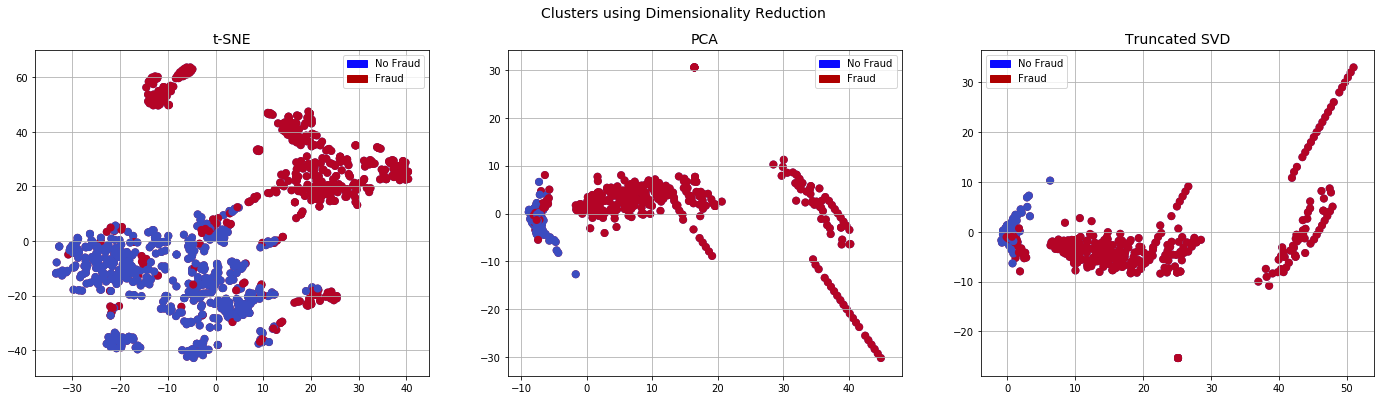

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

## Classifiers (UnderSampling):
The dataset is trained on five types of classifiers and the effectiveness of each is determined through cross validation score. Before we have to split our data into training and testing sets and separate the features from the labels.

In [26]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [27]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [29]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Random Forest Classifier": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [30]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 92.0 % accuracy score
Classifiers:  SVC Has a training score of 92.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 93.0 % accuracy score
Classifiers:  XGBClassifier Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 90.0 % accuracy score


<br>

Here, we can observe that **Logistic Regression classifier** is more accurate than the other four classifiers in most cases. (We will further analyze Logistic Regression)

GridSearchCV is used to determine the paremeters that gives the best predictive score for the classifiers.

In [31]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

# Random Forest Classifier

rf_clf_params = {'n_estimators': [100, 300, 500], 'max_depth': [1, 3, 5]}
#              'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5]}
rf_clf = GridSearchCV(RandomForestClassifier(), rf_clf_params)
rf_clf.fit(X_train, y_train)

# Random Forest best estimator
rf_clf = rf_clf.best_estimator_

In [32]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('K-Nearest Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('Decision Tree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

rf_score = cross_val_score(rf_clf, X_train, y_train, cv=5)
print('Random Forest Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.13%
K-Nearest Neighbors Cross Validation Score 92.21%
Support Vector Classifier Cross Validation Score 93.26%
Decision Tree Classifier Cross Validation Score 92.73%
Random Forest Classifier Cross Validation Score 92.73%


In [33]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 54938  55310  55649 ... 284804 284805 284806] Test: [    0     1     2 ... 56964 56965 56966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 54938  55310  55649 ... 117212 118135 119590]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113921 113922 113923 ... 174518 174542 175594]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170879 170880 170881 ... 227843 227844 228129]
Train: [     0      1      2 ... 227843 227844 228129] Test: [227845 227846 227847 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


## Learning Curves:
<ul>
<li>The <b>wider the  gap</b>  between the training score and the cross validation score, the more likely your model is <b>overfitting (high variance)</b>.</li>
<li> If the score is low in both training and cross-validation sets</b> this is an indication that our model is <b>underfitting (high bias)</b></li>
<li><b> Logistic Regression Classifier</b>  shows the best score in both training and cross-validating sets.</li>
</ul>

In [34]:
# Let's Plot the Learning Curves
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, axes = plt.subplots(2,2, figsize=(20,14), sharey=True, squeeze=False)
    axes = axes.flatten()
    if ylim is not None:
        plt.ylim(*ylim)
    estimators = [estimator1, estimator2, estimator3, estimator4]

    Titles = ["Logistic Regression\n Learning Curve", "K- Nearest Neighbors\n Learning Curve", 
              "Support Vector Classifier\n Learning Curve", "Decision Tree Classifier\n Learning Curve"]
    # First Estimator
    for i in range(4):
        train_sizes, train_scores, test_scores = learning_curve(
            estimators[i], X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        axes[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="#ff9124")
        axes[i].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
        axes[i].plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
                 label="Training score")
        axes[i].plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
                 label="Cross-validation score")
        axes[i].set_title(Titles[i], fontsize=14)
        axes[i].set_xlabel('Training size (m)')
        axes[i].set_ylabel('Score')
        axes[i].grid(True)
        axes[i].legend(loc="best")

    return plt

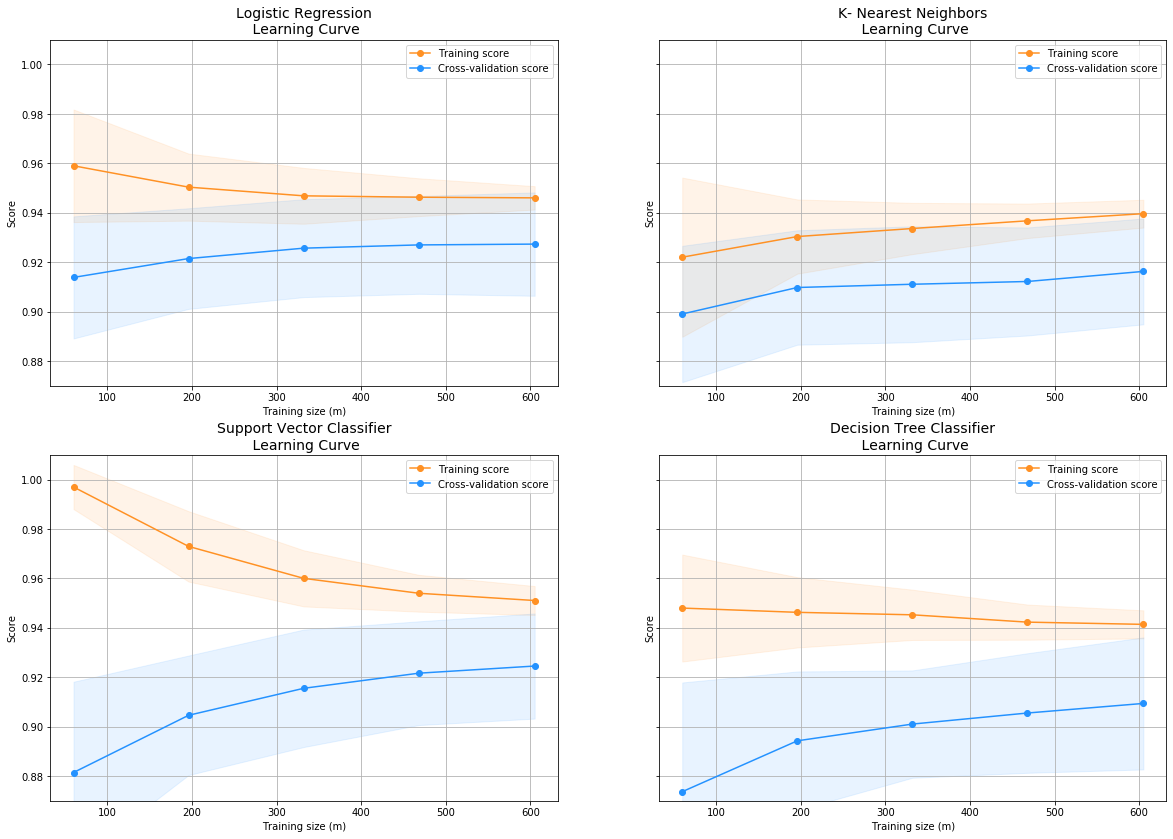

In [35]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)
plt.show()

In [36]:
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

rf_pred = cross_val_predict(rf_clf, X_train, y_train, cv=5)

In [37]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train, rf_pred))

Logistic Regression:  0.9724845190394799
KNears Neighbors:  0.9180805009947044
Support Vector Classifier:  0.9680643895878281
Decision Tree Classifier:  0.9246441480568243
Random Forest Classifier:  0.9236984785227942


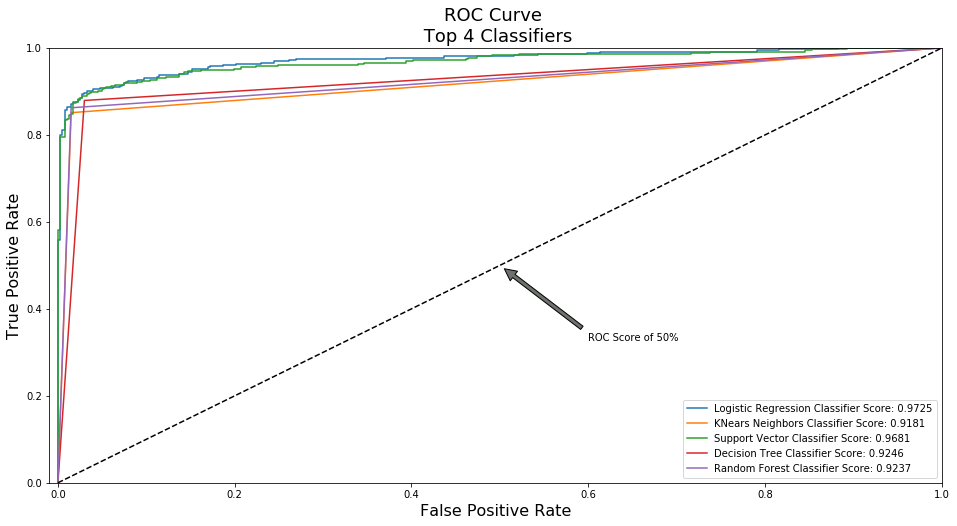

In [38]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_train, rf_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr, rf_fpr, rf_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, rf_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('ROC Score of 50% \n', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr, rf_fpr, rf_tpr)
plt.show()

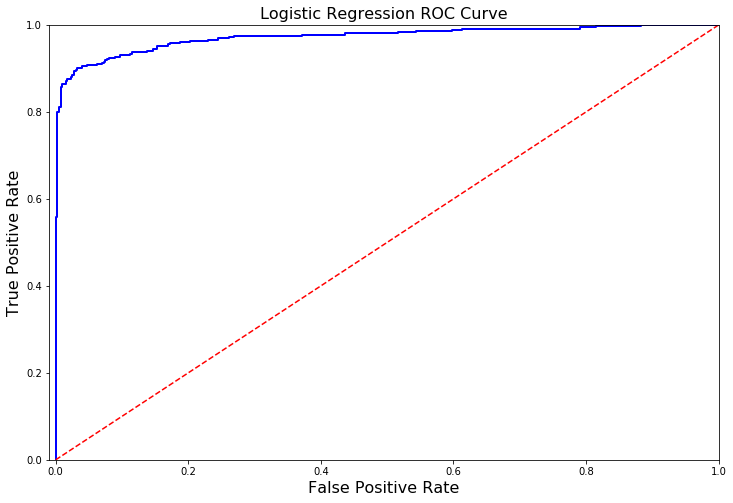

In [39]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [40]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [41]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 8)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 8)
# How it should look like
print('How it should be: \n')
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print('---' * 8)

------------------------
Overfitting: 

Recall Score: 0.90
Precision Score: 0.89
F1 Score: 0.89
Accuracy Score: 0.90
------------------------
How it should be: 

Recall Score: 0.18
Precision Score: 0.00
F1 Score: 0.00
Accuracy Score: 0.80
------------------------


In [42]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [43]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.08


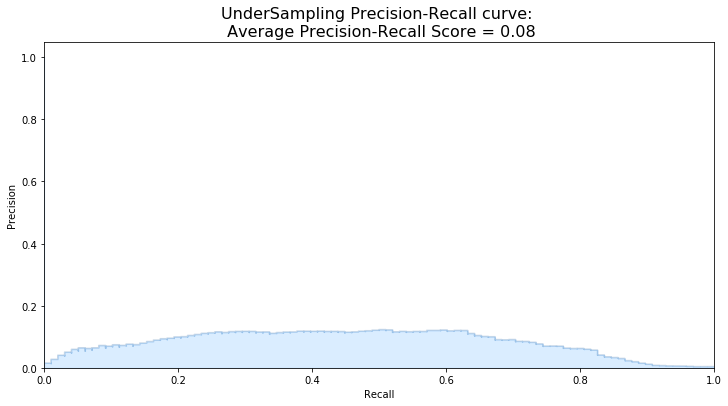

In [44]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score = {0:0.2f}'.format(
          undersample_average_precision), fontsize=16)
plt.show()

## SMOTE Technique (Over-Sampling):

**SMOTE** stands for Synthetic Minority Over-sampling Technique.  Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems". <br>

**Understanding SMOTE:**
<ul>
<li> <b> Solving the Class Imbalance: </b> SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class. </li>
<li><b>Location of the synthetic points: </b>   SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points. </li>
<li> <b>Final Effect:  </b> More information is retained since we didn't have to delete any rows unlike in random undersampling.</li>
<li><b> Accuracy || Time Tradeoff: </b> Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.</li>

</ul>


In [45]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 18)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 18)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
------------------------------------------------------

accuracy: 0.9705943330371106
precision: 0.06417730052975404
recall: 0.9111976630963973
f1: 0.11872623834343714
------------------------------------------------------


In [46]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.86      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.60     56961
weighted avg       1.00      0.99      0.99     56961



In [47]:
y_score = best_est.decision_function(original_Xtest)

In [48]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.76


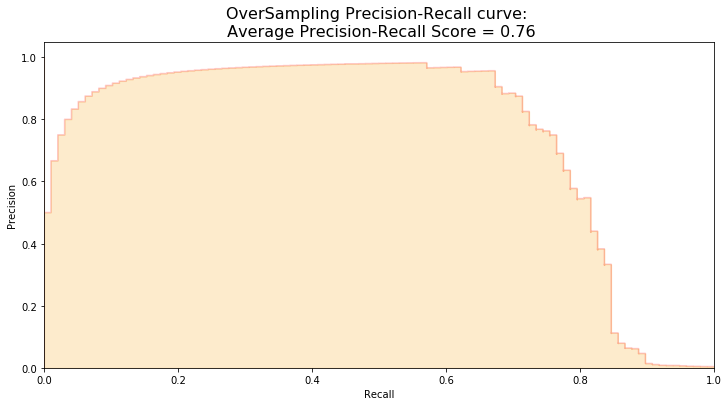

In [49]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score = {0:0.2f}'.format(
          average_precision), fontsize=16)
plt.show()

In [50]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)

# This will be the data were we are going to
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [51]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :3.0907392501831055 sec


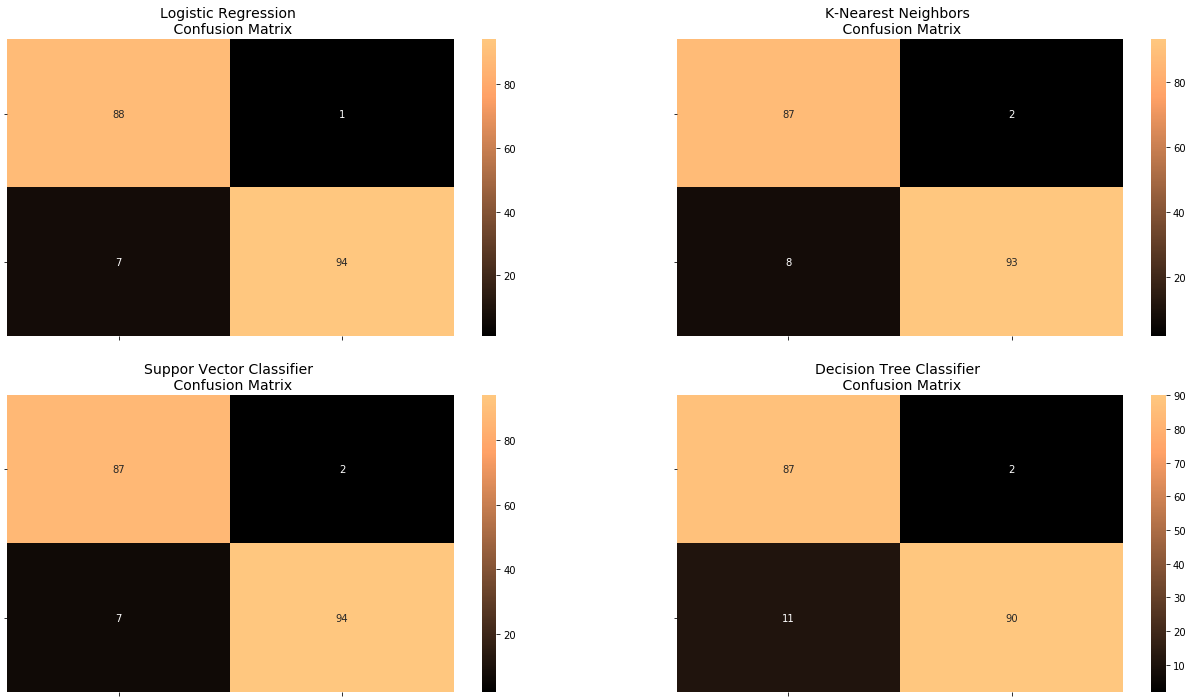

In [52]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, axes = plt.subplots(2, 2,figsize=(22,12), squeeze=True)
axes = axes.flatten()

Titles = ["Logistic Regression \n Confusion Matrix", "K-Nearest Neighbors \n Confusion Matrix",
         "Suppor Vector Classifier \n Confusion Matrix", "Decision Tree Classifier \n Confusion Matrix"]
Classifiers = [log_reg_cf, kneighbors_cf, svc_cf, tree_cf]

for i in range(4):
    sns.heatmap(Classifiers[i], ax=axes[i], annot=True, cmap=plt.cm.copper)
    axes[i].set_title(Titles[i], fontsize=14)
    axes[i].set_xticklabels(['', ''], fontsize=14, rotation=90)
    axes[i].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

In [53]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('K-Nearest Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        89
           1       0.99      0.93      0.96       101

    accuracy                           0.96       190
   macro avg       0.96      0.96      0.96       190
weighted avg       0.96      0.96      0.96       190

K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        89
           1       0.98      0.92      0.95       101

    accuracy                           0.95       190
   macro avg       0.95      0.95      0.95       190
weighted avg       0.95      0.95      0.95       190

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        89
           1       0.98      0.93      0.95       101

    accuracy                           0.95       190
   macro avg       0.95      0.95      0.95       190
weigh

In [54]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)
# Note how high is accuracy score it can be misleading! 
final_df = final_df.sort_values(by='Score', ascending=False).reset_index(drop=True)
final_df

,Technique,Score
0,Oversampling (SMOTE),0.987957
1,Random UnderSampling,0.957895
